# GeoDataFrame of US Census Tract

In [1]:
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as  plt
import contextily as cx 
from matplotlib.colors import LinearSegmentedColormap

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-d243db8cb592>:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os


## Load Data
The shapefile of census tract is available to download from the US Census Bureau. This note book is used to load and visualise the data relating to the [US Census Tracts](https://www2.census.gov/geo/tiger/TIGER2021/TRACT/). This should be downloaded and store into a file named "shafile". Otherwise, adapt the following code chunk as appropriate to load the shapefiles.
Each file contains census tract of a given State. We will loop through all the files to get all the geospatial data.

We will also load the food desert data for some preliminary visualisation.

In [4]:
# get a list of all state fips code
state_fips = [x for x in range(1,57)]
remove = [2,3,7,14,15,43,52]
for x in remove:
    state_fips.remove(x)
state_fips = [str(x).zfill(2) for x in state_fips]

# create a list of all the states
files = ["./shapefile/tl_2021_{}_tract".format(x) for x in state_fips]


In [7]:
gdf = pd.DataFrame()
state = gpd.GeoSeries()
for file in files:
    # load the data to geopandas GeoDataFrame
    data = gpd.read_file(file)
    gdf = pd.concat([gdf,data], ignore_index = True)

    # add state polygon to state gdf
    state[len(state)] = data.unary_union
    

In [8]:
fd = pd.read_csv("data.csv",usecols=[1,4])
fd['CensusTract'] = fd['CensusTract'].astype('str')
fd['CensusTract'] = fd['CensusTract'].apply(lambda x: x.zfill(11))
fd.head()

,CensusTract,LILATracts_1And10
0,01001020100,0
1,01001020200,0
2,01001020300,0
3,01001020400,0
4,01001020500,0


In [9]:
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727..."
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613..."
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543..."
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557..."
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820..."


In [10]:
df = gdf.merge(fd, left_on = 'GEOID', right_on = 'CensusTract')
df = df[['GEOID','geometry','LILATracts_1And10']]

In [11]:
# check the crs
df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [12]:
# compute the area of each tract
# transform to a metric crs
df = df.to_crs("ESRI:102003")

# get area
df['area'] = df.area

In addition, we will also transform the state geoSeries to the CRS of ESRI:102003 for visualisation

In [13]:
state = state.set_crs("EPSG:4269")
state = state.to_crs("ESRI:102003")

## Data Viz

In [14]:
# Create an array with the colors you want to use
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#DCDCDC'), (1, '#cf1248')])

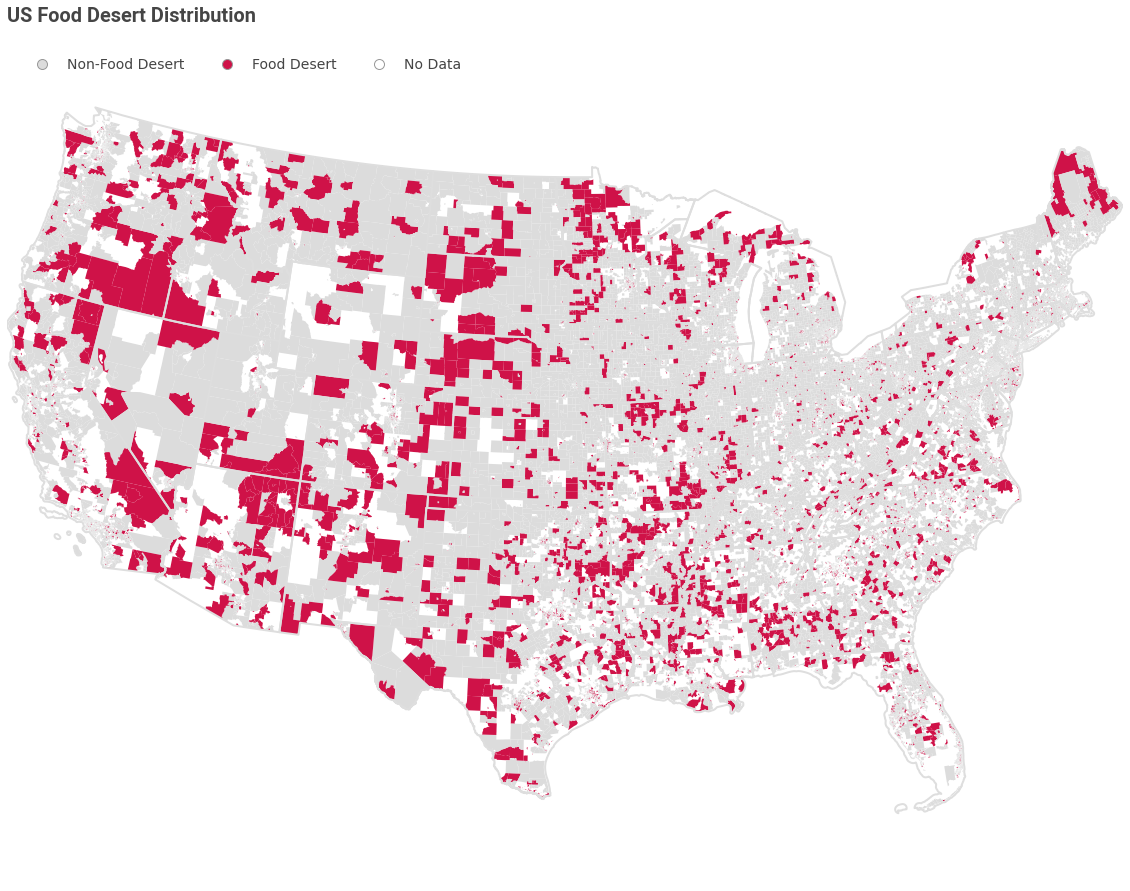

In [16]:

# template to plot the great paris map overlay
fig, ax = plt.subplots(figsize=(20,20 ))

#plot df 
df.plot(ax =ax ,column = "LILATracts_1And10",cmap = cmap,
                         missing_kwds={"color": "#fffff"}
        )
state.boundary.plot(ax=ax,edgecolor = "#DEDEDE",linewidth = 2)

# Final touches
ax.margins(x= 0, y=0.1)
ax.set_axis_off()
ax.set_title("US Food Desert Distribution", loc = "left",
             fontdict={'weight':"bold","family":"roboto","size":20, 'color':"#454545"},
             pad = 0.2)

#legend
from matplotlib.lines import Line2D
colour = ['#DCDCDC', '#CF1248','#FFFFFF']
lines = [Line2D([0], [0], marker = 'o',color=c, markeredgecolor= "#999999", linewidth=0, markersize=10) for c in colour] #defining the handles
labels = ['Non-Food Desert' , 'Food Desert', 'No Data' ] #define the labels
plt.legend(lines,labels,prop={'size': 14}, 
           #customise the legend box
           frameon=False, facecolor= '#FFFFFF', 
           loc = 'upper left',
           bbox_to_anchor = (0,1), 
           alignment = "left",
           borderpad = 1,
           labelspacing = 1,
           mode = None,
          fontsize = 60, labelcolor = "#454545",ncol = 3,)
fig.savefig("food_desert_map.png",dpi = 300)


# Export
While the shapefile geometry may not be useful for our analysis moving forward, the area of the census track could be useful. We will export the area stored in the df dataframe

In [17]:
df.drop(columns  = 'geometry').to_csv("tract_area.csv", index = False)